In [1]:
from cliff import Cliff
import torch, torch.nn as nn, torch.nn.functional as F, torch.distributions as distrib
import matplotlib.pyplot as plt
import collections, typing
from tqdm import trange

In [17]:
env = Cliff()

In [18]:
action_tab = nn.Embedding(24, 4) # mapping: observation -> action
params_init = next(iter(action_tab.parameters())).clone()
logs = collections.defaultdict(list)

In [19]:
class Episode(typing.NamedTuple):
  states: list
  actions: list
  rewards: list

In [20]:
def run_episode(eps=.05):
  states, actions, rewards = [], [], []
  state = env.reset()
  while True:
    states.append(state)

    # eps-greedy policy
    if torch.rand(()) > eps:
      action_logits = action_tab(torch.as_tensor(state))
      #action = distrib.Categorical(logits=action_logits).sample().item()
      action = action_logits.argmax()
    else:
      action = torch.randint(high=4,size=())
    action = action.item()

    state, reward, done = env.step(state, action)
    actions.append(action)
    rewards.append(reward)
    if done:
      break
  return Episode(states, actions, rewards)

In [21]:
F.softmax(action_tab(torch.as_tensor(16)), dim=0), run_episode()

(tensor([0.2467, 0.3963, 0.1258, 0.2312], grad_fn=<SoftmaxBackward0>),
 Episode(states=[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16], actions=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2], rewards=[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [24]:
for step in (pbar := trange(10000)):
  # record episodes
  episodes = []
  for _ in range(10):
    episode = run_episode()
    episodes.append(episode)

  # compute expected reward (averaged over multiple episodes)
  expected_reward, average_reward = 0., 0.
  for states, actions, rewards in episodes:
    states, actions = (torch.as_tensor(p) for p in (states, actions))
    eprew = sum(rewards) # compute episode's reward
    logits = action_tab(states)
    logliks = F.log_softmax(logits, dim=-1)[torch.arange(len(states)), actions]
    expected_reward += eprew * torch.sum(logliks)
    average_reward += eprew
  expected_reward /= len(episodes)
  average_reward /= len(episodes)

  # clear gradients
  for p in action_tab.parameters():
    p.grad = None
  # compute backward pass to fill out p.grad for all parameters p
  expected_reward.backward()
  # run gradient ascent step
  lr = 1e-3
  for p in action_tab.parameters():
    p.data += lr * p.grad
    
  # compute model entropy and bookkeeping
  log_params = F.log_softmax(next(iter(action_tab.parameters())), dim=-1)
  entropies = -(log_params.exp() * log_params).sum(-1)
  model_entropy = entropies.mean()
  pbar.set_description(f"average_reward={average_reward:7.2f}, average_model_entropy={model_entropy.item():.03f}")
  logs["average_reward"].append(average_reward)
  logs["average_model_entropy"].append(model_entropy.item())

average_reward=   9.20, average_model_entropy=0.607: 100%|██████████| 10000/10000 [01:57<00:00, 84.78it/s]


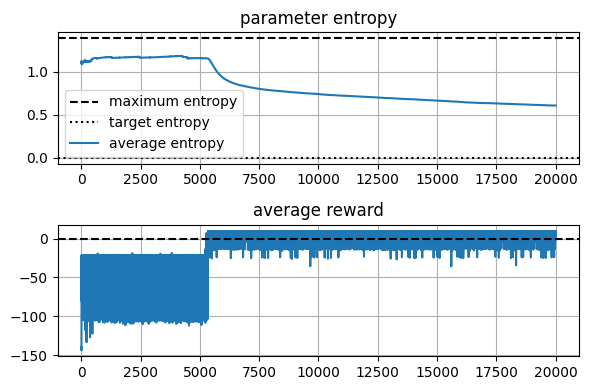

In [25]:
plt.figure(figsize=(6,4))

# plot entropy
plt.subplot(2,1,1)
plt.title("parameter entropy")
plt.axhline(torch.log(torch.as_tensor(4.)),c="k",ls="--",label="maximum entropy")
plt.axhline(0,c="k",ls=":",label="target entropy")
plt.plot(logs["average_model_entropy"], label="average entropy")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title("average reward")
plt.grid(True)
plt.plot(logs["average_reward"])
plt.axhline(0,c="k",ls="--")

plt.tight_layout();

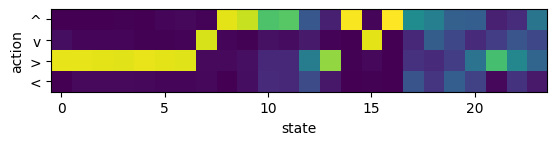

In [26]:
plt.xlabel("state")
plt.ylabel("action")
plt.yticks(range(4), [a for a, _ in env.MOVE_NAME_AND_DIR.values()])
plt.imshow(F.softmax(next(iter(action_tab.parameters())), dim=-1).T.detach().numpy());

In [27]:
for y in range(3):
  for x in range(8):
    state = torch.as_tensor(env.pos_to_state((y,x)))
    action = action_tab(state).argmax().item()
    action_name, _ = env.MOVE_NAME_AND_DIR[action]
    print(action_name, end="")
  print()

>>>>>>>v
^^^^>>^v
^^^^>>>^
